## Importing Libraries

In [301]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.utils import shuffle
from scipy.ndimage import rotate, shift
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Data Preprocessing (Labeled)

In [302]:
# 0 : Anger
# 1 : Disgust
# 2 : Fear
# 3 : Happiness
# 4 : Sadness
# 5 : Surprise
# 6 : Neutral
# 7 : Contempt

df = pd.read_csv('ckextended.csv', delimiter=',', dtype=str, header=0)

# downsample the neutral emotion and make a new dataframe with the more balanced dataset
emotion_6_df = df[df['emotion'] == '6']
emotion_6_limited = emotion_6_df.sample(n=70, random_state=42)
other_emotions_df = df[df['emotion'] != '6']
new_df = pd.concat([other_emotions_df, emotion_6_limited])

labels = new_df['emotion']

# check the counts of each emotion after downsampling
print(new_df['emotion'].value_counts())

# convert strings into individual columns (2304 columns as a result)
new_df["pixels"] = new_df["pixels"].apply(lambda x: np.array(x.split(), dtype=int))
images = np.stack(new_df["pixels"].values)
# normalize them so the values range from 0-1
dflabeled = pd.DataFrame(images / 255.0)

# check to see the shape of your labeled dataset
print(dflabeled.shape)

# also the first few rows
dflabeled.head()

emotion
5    83
6    70
3    69
1    59
0    45
4    28
2    25
7    18
Name: count, dtype: int64
(397, 2304)


,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0.180392,0.196078,0.196078,0.105882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.568627,0.607843,0.694118,0.141176,0.156863,0.176471,0.168627,0.176471,0.176471,0.188235
1,0.168627,0.188235,0.188235,0.192157,0.188235,0.031373,0.027451,0.031373,0.035294,0.039216,...,0.309804,0.407843,0.443137,0.000000,0.003922,0.000000,0.015686,0.086275,0.109804,0.211765
2,0.294118,0.203922,0.074510,0.090196,0.109804,0.117647,0.094118,0.086275,0.054902,0.031373,...,0.698039,0.105882,0.105882,0.109804,0.223529,0.235294,0.294118,0.301961,0.286275,0.282353
3,0.200000,0.160784,0.121569,0.109804,0.070588,0.074510,0.070588,0.070588,0.070588,0.101961,...,0.584314,0.639216,0.564706,0.443137,0.262745,0.831373,1.000000,1.000000,1.000000,1.000000
4,0.345098,0.325490,0.341176,0.337255,0.305882,0.243137,0.125490,0.078431,0.039216,0.039216,...,0.443137,0.254902,0.117647,0.066667,0.066667,0.098039,0.090196,0.133333,0.196078,0.141176


Here I have tried data augmentation for under represented classes along with downsampling for the over represented neutral class, but after seeing the result, it seemed it was better to simply downsample the neutral class

In [303]:
# def augment_image(img, n_aug=1):
#     """Apply random augmentations to a flat 2304 array (48x48)."""
#     img = img.reshape(48, 48)
#     augmented = []
#     for _ in range(n_aug):
#         aug = img.copy()
#         # Random horizontal flip
#         if np.random.rand() > 0.5:
#             aug = np.fliplr(aug)
#         # Random small rotation
#         angle = np.random.uniform(-15, 15)
#         aug = rotate(aug, angle, reshape=False, mode='nearest')
#         # Random shift
#         shift_x = np.random.uniform(-2, 2)
#         shift_y = np.random.uniform(-2, 2)
#         aug = shift(aug, [shift_x, shift_y], mode='nearest')
#         augmented.append(aug.flatten())
#     return augmented

# # Prepare to collect balanced samples
# balanced_data = []
# balanced_labels = []

# for emotion in range(8):
#     class_indices = np.where(df['emotion'].astype(int) == emotion)[0]
#     class_samples = dflabeled.iloc[class_indices].values
#     n_samples = len(class_samples)
#     if emotion == 6:  # Neutral: downsample to 100
#         selected_idx = np.random.choice(n_samples, 100, replace=False)
#         balanced_data.append(class_samples[selected_idx])
#         balanced_labels.extend([emotion] * 100)
#     else:  # All other emotions: augment up to 100
#         if n_samples >= 100:
#             selected_idx = np.random.choice(n_samples, 100, replace=False)
#             balanced_data.append(class_samples[selected_idx])
#             balanced_labels.extend([emotion] * 100)
#         else:
#             # Keep all originals
#             balanced_data.append(class_samples)
#             balanced_labels.extend([emotion] * n_samples)
#             # Augment to reach 100
#             n_to_augment = 100 - n_samples
#             augments = []
#             for i in range(n_to_augment):
#                 idx = np.random.randint(0, n_samples)
#                 augments.extend(augment_image(class_samples[idx], n_aug=1))
#             balanced_data.append(np.array(augments))
#             balanced_labels.extend([emotion] * n_to_augment)

# # Concatenate and shuffle
# X_balanced = np.vstack(balanced_data)
# y_balanced = np.array(balanced_labels)
# dflabeled = pd.DataFrame(X_balanced)
# dflabeled['emotion'] = y_balanced
# dflabeled = shuffle(dflabeled, random_state=42).reset_index(drop=True)


## Data Preprocessing (Unlabeled)

In [304]:
lfw_people = fetch_lfw_people(color=False,resize=1 )
images = lfw_people.images
# images are originally 64*64 so resize them to 48*48
images_resized = np.array([Image.fromarray(img.copy()).resize((48, 48)) for img in images])
# and then flatten
dfunlabeled = pd.DataFrame(images_resized.reshape(images_resized.shape[0], -1))  # Flatten each image into a row
print(dfunlabeled.head())
print(dfunlabeled.shape)

       0         1         2         3         4         5         6     \
0  0.175365  0.155835  0.122172  0.121378  0.141020  0.151173  0.172042   
1  0.619996  0.626774  0.666525  0.670796  0.634026  0.630776  0.608765   
2  0.308447  0.330070  0.356456  0.427143  0.534375  0.597441  0.598373   
3  0.044503  0.043398  0.044341  0.048824  0.053939  0.058008  0.060718   
4  0.107761  0.105707  0.102022  0.114983  0.111673  0.105385  0.116671   

       7         8         9     ...      2294      2295      2296      2297  \
0  0.285190  0.395345  0.471170  ...  0.139275  0.097444  0.082249  0.071764   
1  0.629399  0.634947  0.617532  ...  0.868025  0.771053  0.642442  0.443127   
2  0.633988  0.653846  0.662327  ...  0.697456  0.742815  0.852945  0.877470   
3  0.053295  0.051378  0.055073  ...  0.471199  0.480307  0.478911  0.459677   
4  0.143044  0.144915  0.122636  ...  0.055076  0.032743  0.028901  0.044695   

       2298      2299      2300      2301      2302      2303  
0  0

## Feature Extraction with PCA and SVD

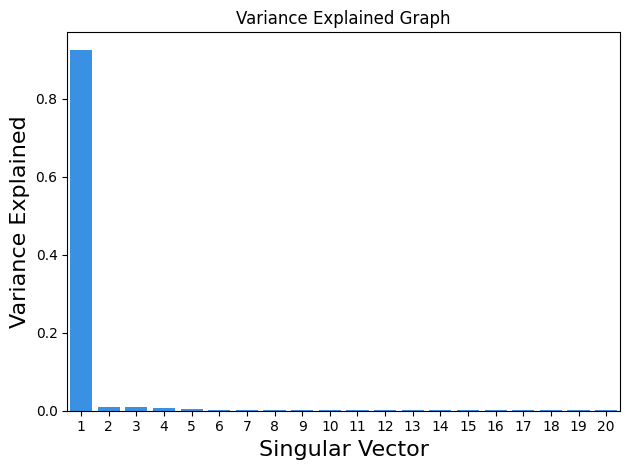

(13630, 100)
(397, 100)
397


In [305]:
# in order to leverage the unlabeled data, we create a combined dataframe with labeled and unlabeled data
# and create a 'face space' and then analyze the principal components 
# onto which we will project the labeled data only and use that to train the SVM

dfcombined = pd.concat([dflabeled, dfunlabeled])
ua, sa, va = np.linalg.svd(dfcombined.values, full_matrices=False)
var_explained = np.round(sa**2/np.sum(sa**2), decimals=6)

# visualise the most relevant singular vectors
sns.barplot(x=list(range(1, 21)),
            y=var_explained[0:20], color="dodgerblue")

plt.title('Variance Explained Graph')
plt.xlabel('Singular Vector', fontsize=16)
plt.ylabel('Variance Explained', fontsize=16)
plt.tight_layout()
plt.show()

# then use that information to decide how many components to use
pca = PCA(n_components=100)
dfcombinedreduced = pca.fit_transform(dfcombined)
xtotal = dfcombinedreduced[:397]
print(dfcombinedreduced.shape)
print(xtotal.shape)
print(len(labels))

As we can see, the bar graph tells us that over 95% of the data is being represented by the first component. We can now take just 2 components for visualization. However for the actual model training I will be taking 100 components because it is still a relatively low computational cost.

## Visualizing a sample with SVM Decision Boundary

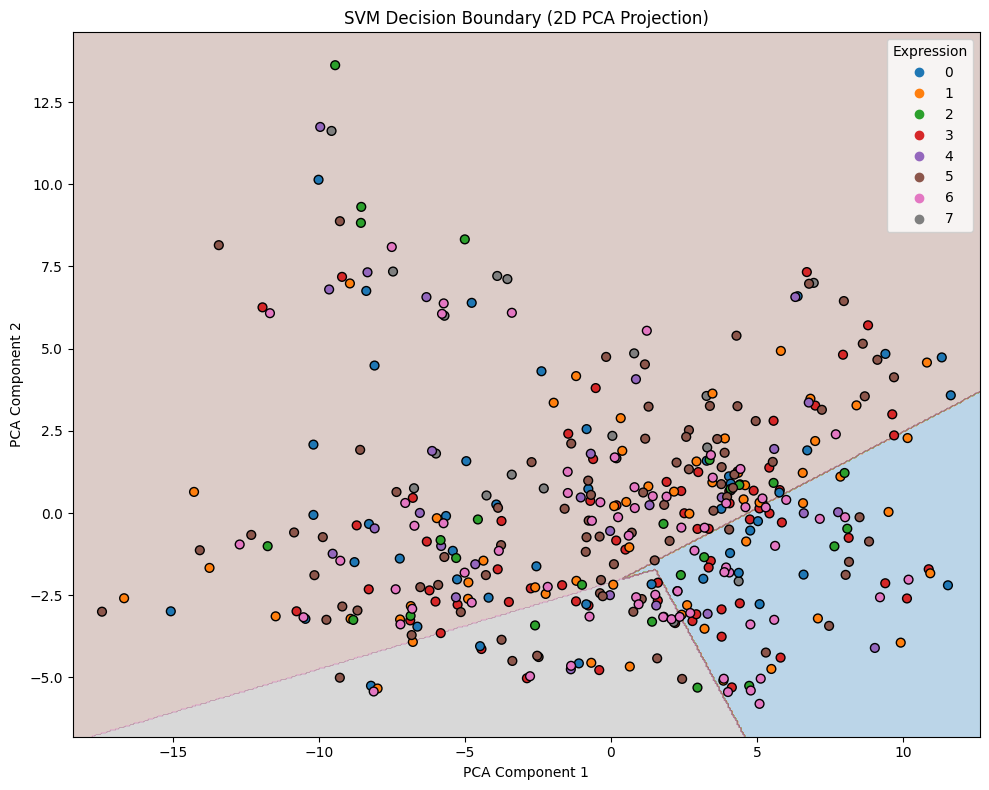

In [306]:
pca_vis = PCA(n_components=2)
xtotal_vis = pca_vis.fit_transform(dflabeled)

svm_2d = SVC(kernel='linear', C=1)
svm_2d.fit(xtotal_vis, labels.astype(int))

x_min, x_max = xtotal_vis[:, 0].min() - 1, xtotal_vis[:, 0].max() + 1
y_min, y_max = xtotal_vis[:, 1].min() - 1, xtotal_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Predict class for each point in mesh
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
cmap = ListedColormap(plt.cm.tab10.colors[:len(np.unique(labels))])
plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)

# Plot training points
scatter = plt.scatter(xtotal_vis[:, 0], xtotal_vis[:, 1], c=labels.astype(int), cmap=cmap, edgecolor='k', s=40)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('SVM Decision Boundary (2D PCA Projection)')
plt.legend(*scatter.legend_elements(), title="Expression")
plt.tight_layout()
plt.show()



## Training SVM Classifier

In [307]:
xtrain, xtest, ytrain, ytest = train_test_split(xtotal, labels, test_size=0.2, random_state=42, stratify=labels)
classnames = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral', 'Contempt']
model = SVC(kernel='linear', class_weight='balanced', C=0.1, gamma='scale')
model.fit(xtrain, ytrain)
ypred = model.predict(xtest)

We use hyper parameter tuning and cross validation. We have used the hyper parameters obtained from this to train the model

In [308]:
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto', 0.01, 0.1, 1]
# }
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# grid_search = GridSearchCV(
#     SVC(),
#     param_grid,
#     scoring='f1_weighted',  # or 'f1_weighted' for imbalanced data
#     cv=cv,
#     n_jobs=-1,           # Use all CPU cores
#     verbose=2
# )


# grid_search.fit(xtotal, labels)


# print("Best parameters:", grid_search.best_params_)
# print("Best cross-validated score:", grid_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

## Model Evaluation

0.775
              precision    recall  f1-score   support

       Anger       0.47      0.78      0.58         9
     Disgust       1.00      0.92      0.96        12
        Fear       0.60      0.60      0.60         5
   Happiness       0.93      1.00      0.97        14
     Sadness       0.33      0.17      0.22         6
    Surprise       1.00      0.88      0.94        17
     Neutral       0.82      0.64      0.72        14
    Contempt       0.40      0.67      0.50         3

    accuracy                           0.78        80
   macro avg       0.69      0.71      0.69        80
weighted avg       0.80      0.78      0.78        80



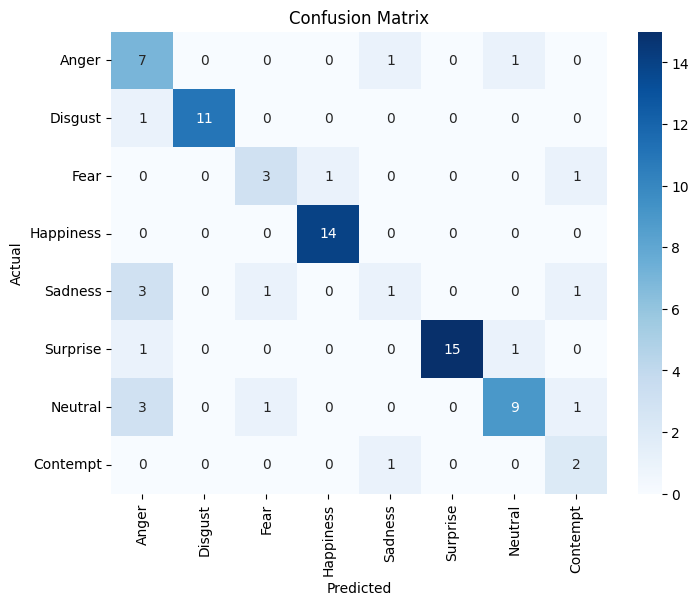

In [309]:
accuracy = accuracy_score(ytest, ypred)
print(accuracy)
print(classification_report(ytest, ypred, target_names=classnames))

cm = confusion_matrix(ytest, ypred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classnames, yticklabels=classnames)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()